# **Transfer Learning con timm**

## **List Pretrained Models**

- timm contiene già dei (tantissimi) modelli e delle versioni di questi implementate e addestrate su ImageNet o altri dataset
- questo ci evita di ricominciare da zero ogni volta (implementazione + training) e provare i modelli che più si adattano al nostro dataset

In [ ]:
! pip install timm

In [ ]:
import timm
all_models = timm.list_models(pretrained=True)
len(all_models)

1329

## **Imagenette Dataset**


In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torchvision
import torchvision.transforms as T

In [ ]:
_ = torchvision.datasets.Imagenette(
    root='./data',
    # split="train",
    download=True,
)

LABELS_MAP = {
    "n01440764": "fish",
    "n02102040": "dog",
    "n02979186": "speaker",
    "n03000684": "electric saw",
    "n03028079": "church",
    "n03394916": "trumpet",
    "n03417042": "truck",
    "n03425413": "gas pump",
    "n03445777": "golf ball",
    "n03888257": "parachute"
}

class ImageFolderDataset(Dataset):

  def __init__(
      self,
      root_dir: str, # "./data/imagenette2"
      split: str = "train",
      labels_map: dict = LABELS_MAP,
      transform: callable = None
  ) -> None:

    self.split_dir = os.path.join(root_dir, split) # e.g. "./data/imagenette2/train"

    # mi serve perchè ad ogni label deve essere associato un numero
    # e.g. { "n01440764": 0, "n02102040": 1}
    label2target = {
        label: idx for idx, label in enumerate(labels_map.keys())
    }

    self.images = []
    self.targets = []
    self.labels = []
    for class_id in os.listdir(self.split_dir):
      class_dir_path = os.path.join(self.split_dir, class_id)
      images = os.listdir(class_dir_path)
      self.images += [
          os.path.join(class_dir_path, image) for image in images
      ]
      self.targets += [label2target[class_id]]*len(images)

      self.labels += [labels_map[class_id]]*len(images)

    self.transform = transform


  def __getitem__(self, index):

    image_path = self.images[index]
    image_target = self.targets[index]
    image_label = self.labels[index]

    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    return image, image_target

  def __len__(self):
    return len(self.images)


100%|██████████| 1557161267/1557161267 [00:34<00:00, 45601489.94it/s]


Extracting ./data/imagenette2.tgz to ./data


In [ ]:
train_transform = T.Compose([
    T.Resize((224, 224)), # image size di VGG
    T.RandomApply(
        [T.GaussianBlur(3, (0.5, 5)), T.ColorJitter(0.5, 0.1, 0.5, 0.1)],
        p=.5
    ),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.Resize((224, 224)), # image size di VGG
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolderDataset(
    root_dir='./data/imagenette2',
    split="train",
    transform=train_transform,
)

val_dataset = ImageFolderDataset(
    root_dir='./data/imagenette2',
    split="val",
    transform=val_transform,
)

batch_size=32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## **Pre-trained VGG**

In [ ]:
# import torch
from timm import create_model
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
model = create_model("vgg16_bn", pretrained=False, num_classes=10) # no pre-trained weights
# model = create_model("vgg16_bn", pretrained=False) # no pre-trained weights - num_classes == same of ImageNet1K --> 1000 classes
# model = create_model("vgg16_bn", pretrained=True, num_classes=10) # no pre-trained weights

In [ ]:
# model test
x = torch.rand((1, 3, 224, 224))
logits = model(x)
print(logits.shape)

torch.Size([1, 10])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
device = "cpu" # "cuda"
model.to(device);

In [ ]:
# Train the neural network
num_epochs = 5
log_every_n_iter = 5
for epoch in range(num_epochs):
  # train loop
  model.train()
  epoch_loss = 0.0
  print(f"Epoch: {epoch}")
  for i, batch in enumerate(train_loader, 0):
    # batch --> (images, targets)
    x, targets = [el.to(device) for el in batch]
    # set optimizer a zero
    optimizer.zero_grad()
    # forward pass
    logits = model(x)
    # calcolo della loss
    loss = criterion(logits, targets)
    # backward pass
    loss.backward()
    # optimizer step --> update weights
    optimizer.step()
    epoch_loss += loss.item()
    if (i+1) % log_every_n_iter == 0:    # Print every log_every_n_iter mini-batches
        print(f"> iter [{i+1}/{len(train_loader)}] - train_loss={epoch_loss/log_every_n_iter:.4f}")
        epoch_loss = 0.0
    # test loop
  model.eval()
  test_loss = []
  total, correct = 0, 0
  with torch.no_grad():
    for batch in test_loader:
      x, targets = [el.to(device) for el in batch]
      logits = model(x)
      loss = criterion(logits, targets)
      test_loss.append(loss.item())
      # ottengo gli indici dove trovo la max probabilità
      _, preds = torch.max(logits.data, 1)
      total += targets.size(0)
      correct += (preds == targets).sum().item()

  print("Test report:")
  print(f"\t test_loss={sum(test_loss)/len(test_loss):.4f} - test_accuracy={correct/total:.4f}")

  print(" \n *************** \n")

print('Finished Training')

### Inference

In [ ]:
import random
import numpy as np

In [ ]:
idx = random.randint(0, len(val_dataset))
img, target = val_dataset[idx]
gt_label = val_dataset.labels[idx]
image_path = val_dataset.images[idx]
print(img.shape)
# we need to augment the first dimension --> from (C, H, W) -> (B, C, H, W)
x = img.unsqueeze(0)
print(x.shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [ ]:
import torch.nn.functional as F

with torch.no_grad():
  model.eval()
  logits = model(x.to(device))
  probs = F.softmax(logits, 1)
  print(probs.data)
  pred_prob, pred_class = torch.max(probs.data, 1)
  print(pred_class, pred_prob)

tensor([[0.1024, 0.1015, 0.0990, 0.1015, 0.1014, 0.0995, 0.0990, 0.0979, 0.0982,
         0.0995]])
tensor([0]) tensor([0.1024])


In [ ]:
image = Image.open(image_path)

In [ ]:
import matplotlib.pyplot as plt

Predicted class is fish with prob=0.1024 - Ground Truth class is dog


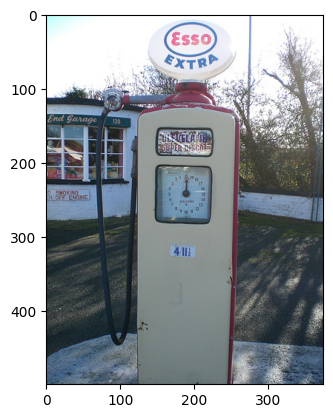

In [ ]:
pred_label_key = list(LABELS_MAP)[pred_class[0]]
pred_label_name = LABELS_MAP[pred_label_key]

print(f"Predicted class is {pred_label_name} with prob={pred_prob[0]:.4f} - Ground Truth class is {gt_label}")
plt.imshow(image)